In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import torch

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


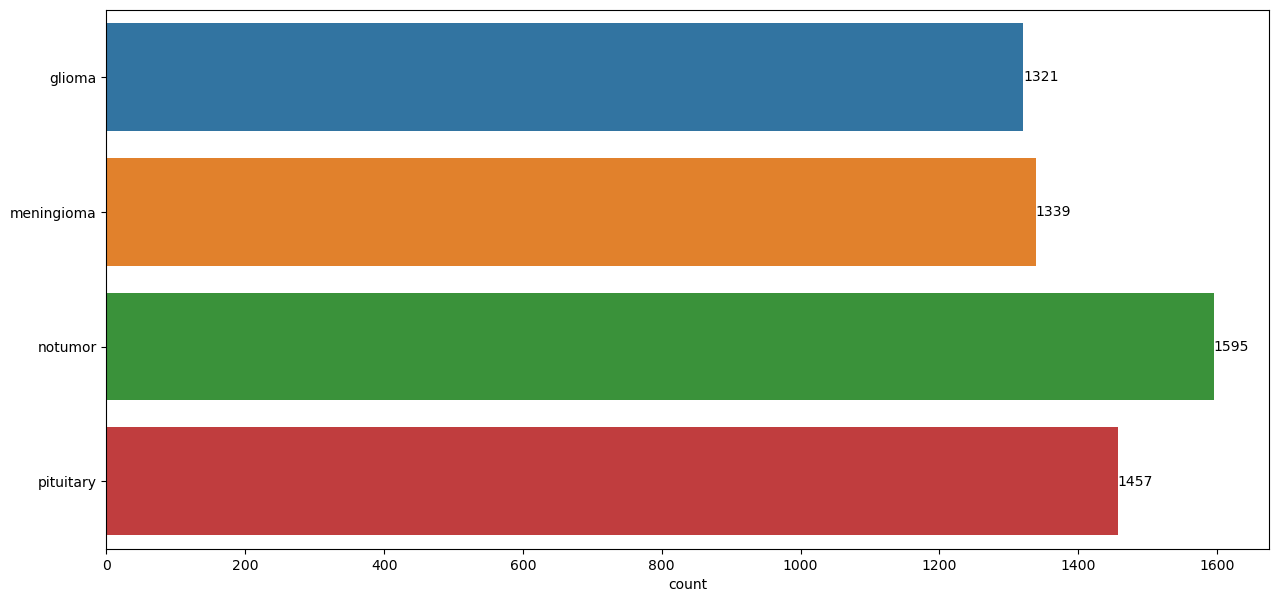

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=dataset.labels)
ax.set_yticklabels(dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()


In [4]:
val_ration = 0.10
val_size = int(len(dataset) * val_ration)
train_size = len(dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size], generator=generator
)
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


Training size: 5141
Validation size: 571


Total images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class Lengths: [300, 306, 405, 300]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


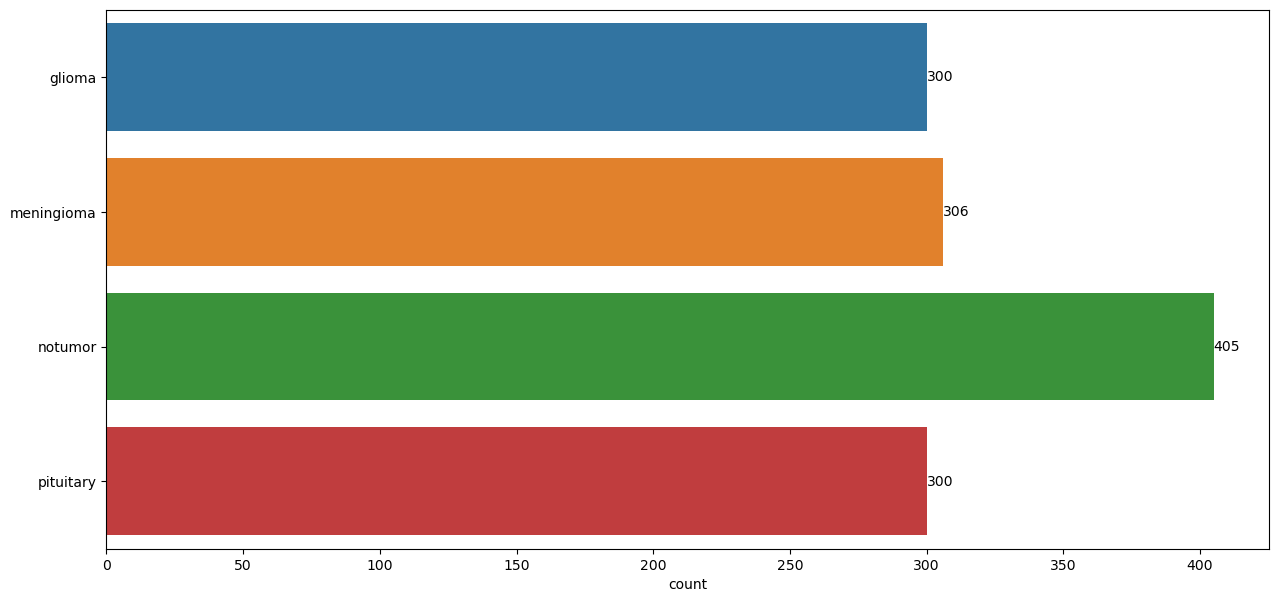

In [5]:
test_dataset_path = "data/Testing"
test_dataset = BrainTumorDataset(test_dataset_path, transform=transform)
print(f"Total images: {len(test_dataset)}")
print("Classes:", test_dataset.classes)
print("Class Lengths:", [test_dataset.labels.count(i) for i in range(len(test_dataset.classes))])
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=test_dataset.labels)
ax.set_yticklabels(test_dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()

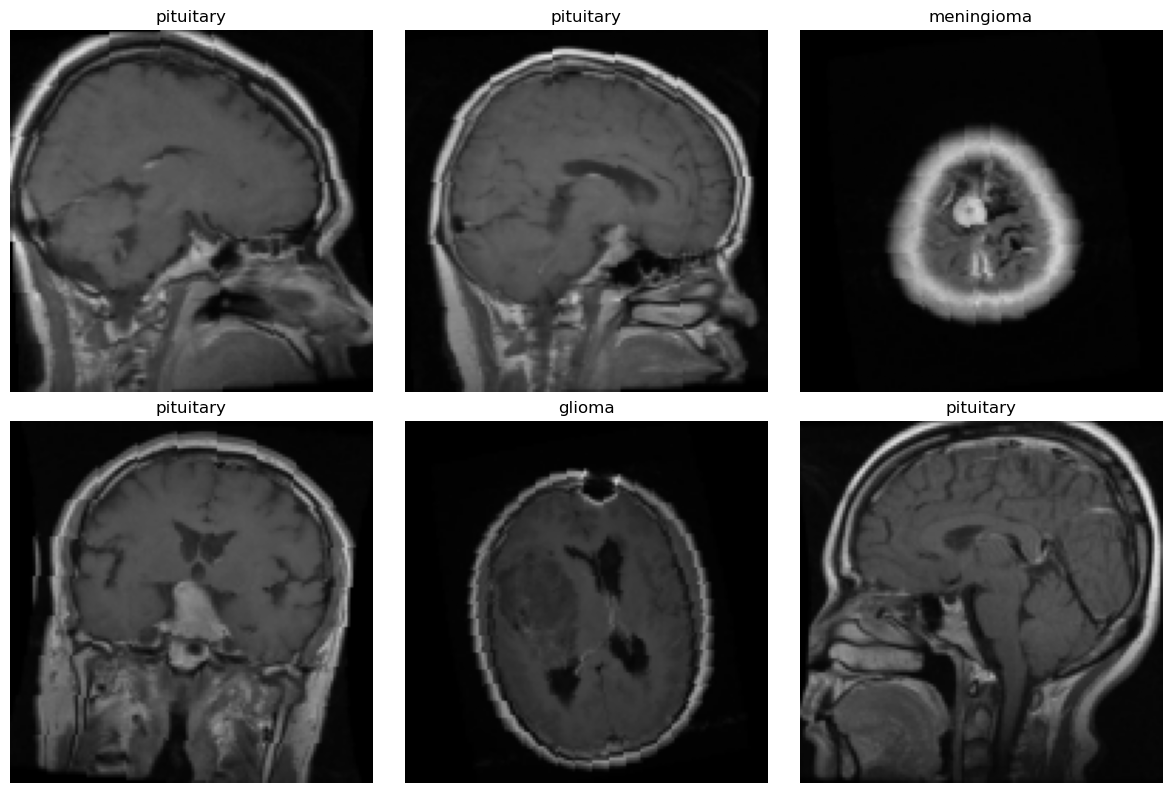

In [6]:
def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]

        # Convert tensor → numpy image
        image_np = image.permute(1,2,0).numpy()

        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [7]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch
class CNN_network(nn.Module):
    def __init__(self, activation="relu", num_classes=4):
        super().__init__()

        activations = {
            "relu": F.relu,
            "tanh": torch.tanh,
            "sigmoid": torch.sigmoid,
            "leaky_relu": F.leaky_relu,
        }
        self.activation = activation
        self.activation_fn = activations[activation]

        # 1. Increase filters slightly to capture more detail
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Deeper filters

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # 2. CALCULATE FLATTEN SIZE
        # Assuming input image is 128x128:
        # After Pool 1: 64x64
        # After Pool 2: 32x32
        # After Pool 3: 16x16
        # Final shape: 128 channels * 16 * 16
        self.flatten_size = 128 * 16 * 16 

        # 3. Standard Dense Layers (No Global Pool bottleneck)
        self.fc1 = nn.Linear(self.flatten_size, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.latest_feature_map = None

    def forward(self, x):
        # Apply Pool at every step to reduce size gradually
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x) # 128 -> 64
        self.latest_feature_map = x.detach().cpu()

        x = self.activation_fn(self.conv2(x))
        x = self.pool(x) # 64 -> 32

        x = self.activation_fn(self.conv3(x))
        x = self.pool(x) # 32 -> 16
        
        # Flatten preserves all spatial info
        x = torch.flatten(x, 1) 

        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        
        x = self.activation_fn(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [10]:
from torchsummary import summary
summary(CNN_network(activation="relu", num_classes=4), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 512]      16,777,728
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 4]             516
Total params: 16,937,156
Trainable params: 16,937,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Fo

In [17]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

In [18]:
def train(model, trainloader, valloader, device, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    history = {
        "train_loss": [], "train_acc": [], 
        "val_loss": [], "val_acc": []
    }

    print(f"{'Epoch':^10} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^12} | {'Val Acc':^12}")
    print("-" * 70)

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Normalize: multiply avg batch loss by batch_size to get total sum
            running_loss += loss.item() * images.size(0) 
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss per image and accuracy
        epoch_loss = running_loss / total 
        epoch_acc = correct / total
        
        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for val_images, val_labels in valloader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                
                # Validation Loss
                v_loss = criterion(val_outputs, val_labels)
                val_running_loss += v_loss.item() * val_images.size(0)
                
                # Validation Accuracy
                _, val_predicted = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()
                
                all_preds.extend(val_predicted.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())
                probs = F.softmax(val_outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = val_running_loss / total_val
        val_acc = correct_val / total_val

        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        # Print normalized metrics (Loss is raw, Accuracy is %)
        print(f"{epoch+1:^10} | {epoch_loss:^12.4f} | {epoch_acc*100:^11.2f}% | {val_loss:^12.4f} | {val_acc*100:^11.2f}%")
    
    return {
        "history": history,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = CNN_network(activation="relu", num_classes=len(dataset.classes))
info = train(model, trainloader, testloader, device, epochs=5)

  Epoch    |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc   
----------------------------------------------------------------------
    1      |    0.8128    |    66.49   % |    0.6865    |    73.61   %
    2      |    0.4987    |    80.78   % |    0.4849    |    79.71   %
    3      |    0.3952    |    85.05   % |    0.3968    |    83.30   %
    4      |    0.3323    |    87.22   % |    0.3668    |    83.22   %
    5      |    0.2869    |    89.04   % |    0.3318    |    85.74   %


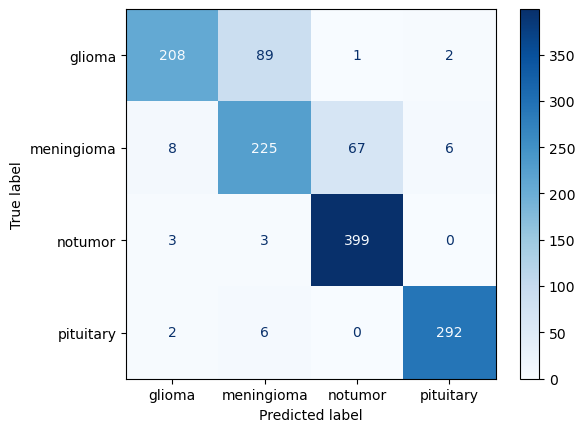

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_true=info['labels'], y_pred=info['preds'], labels=range(len(dataset.classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [22]:
report = classification_report(info['labels'], info['preds'], target_names=dataset.classes)
print("Classification Report: \n",report)

Classification Report: 
               precision    recall  f1-score   support

      glioma       0.94      0.69      0.80       300
  meningioma       0.70      0.74      0.72       306
     notumor       0.85      0.99      0.92       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



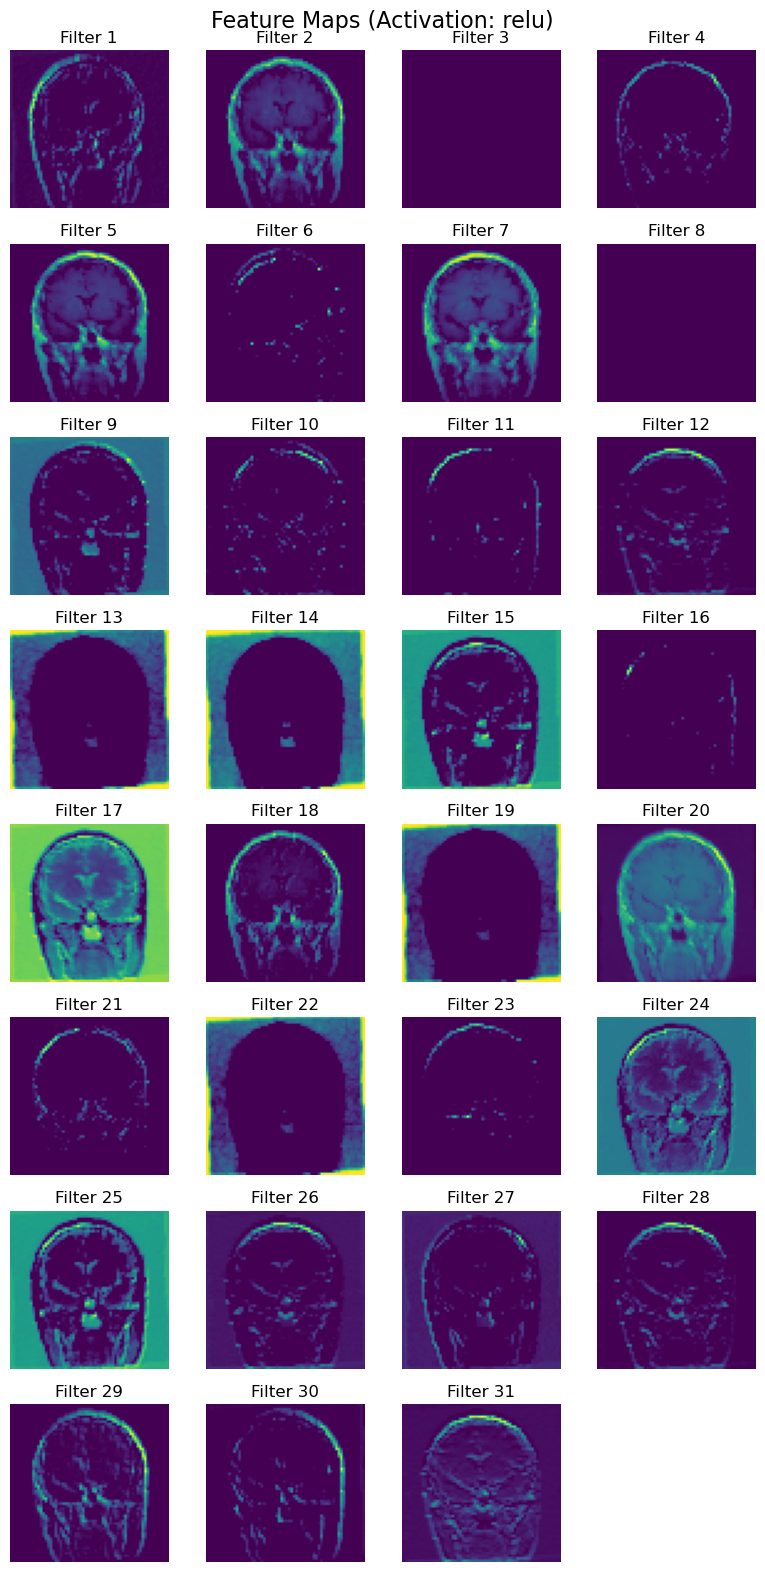

In [24]:
def plot_feature_maps(model): 
    if model.latest_feature_map is None:
        print("No feature map available. Run a forward pass first.")
        return
    
    feature_map = model.latest_feature_map
    num_features = feature_map.shape[0]
    size = feature_map.shape[0]
    cols = 4
    rows = int(np.ceil(num_features / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    plt.suptitle(f"Feature Maps (Activation: {model.activation})", fontsize=16)
    for i in range(num_features):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_map[0, i, :, :], cmap='viridis')
        plt.axis('off')
        plt.title(f"Filter {i+1}")
    plt.tight_layout()
    plt.show()

plot_feature_maps(model)

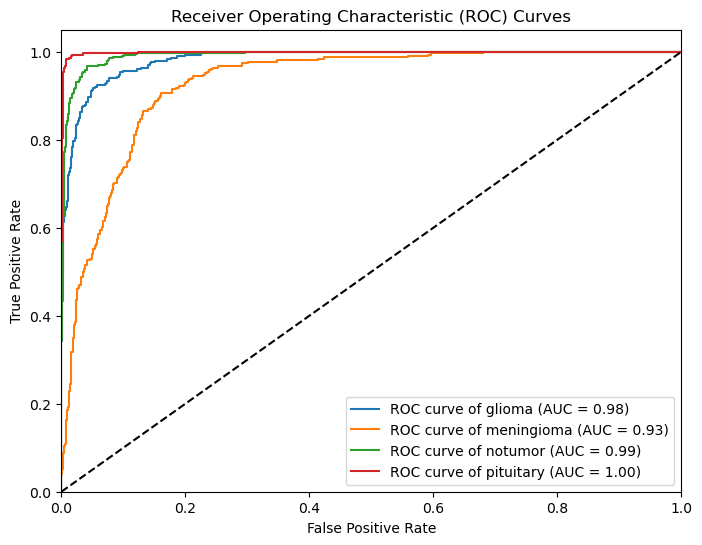

In [25]:
def plot_roc_curve(info, class_names):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt
    import numpy as np

    y_true = np.array(info['labels'])
    y_prob = np.array(info['probs'])

    n_classes = y_prob.shape[1]

    # Binarize labels: 0,1,2,3 → one-hot
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binarized[:, i],
            y_prob[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(info, trainloader.dataset.classes)

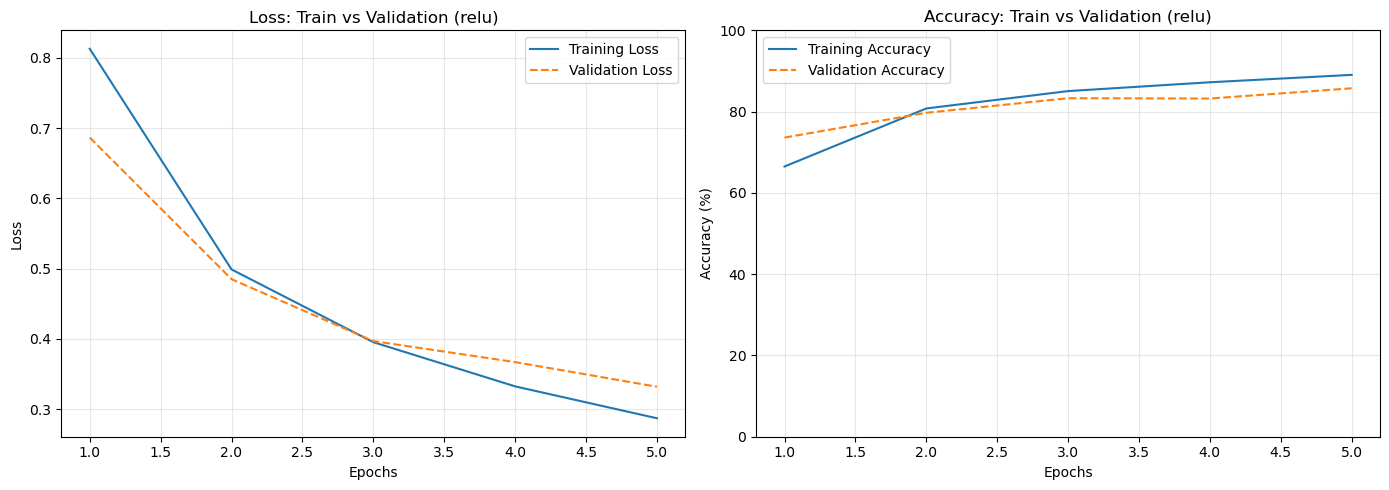

In [28]:
def plot_training_history(history, activation_name):
    """Plots Train vs Validation Loss and Accuracy with proper scaling."""
    epochs = range(1, len(history['train_loss']) + 1)

    # FIX: Convert BOTH to percentage
    train_acc = [acc * 100 for acc in history['train_acc']]
    val_acc = [acc * 100 for acc in history['val_acc']] # <--- Added * 100 here

    plt.figure(figsize=(14, 5))

    # -------- Loss Plot --------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], linestyle='--', label='Validation Loss')
    plt.title(f"Loss: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # -------- Accuracy Plot --------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, linestyle='--', label='Validation Accuracy')
    plt.title(f"Accuracy: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
plot_training_history(info['history'], activation_name=model.activation)

In [36]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    return {
        "accuracy": accuracy,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

eval_info = evaluate(model, testloader, device)
print(f"Test Accuracy: {(eval_info['accuracy']*100)}%")

Test Accuracy: 85.5072463768116%


In [38]:
def confusion_matrix_plot(info, class_names):
    cm = confusion_matrix(y_true=info['labels'], y_pred=info['preds'], labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [ ]:
def compare_activations(activations, trainloader, valloader, testloader, device, epochs=1):
    results = {}
    for activation in activations:
        print(f"\nTraining with activation: {activation}")
        model = CNN_network(activation=activation, num_classes=len(dataset.classes))
        info = train(model, trainloader, valloader, device, epochs=epochs)
        confusion_matrix_plot(info, trainloader.dataset.classes)
        plot_training_history(info['history'], activation_name=activation)
        plot_roc_curve(info, trainloader.dataset.classes)
        plot_feature_maps(model)
        report = classification_report(info['labels'], info['preds'], target_names=dataset.classes)
        print("Classification Report: \n",report)

        test_info = evaluate(model, testloader, device)
        print(f"Test Accuracy: {eval_info['accuracy']:.4f}")
        results[activation] = {
            "train_info": info,
            "test_info": test_info
        }
        
    return results


Training with activation: relu
  Epoch    |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc   
----------------------------------------------------------------------
    1      |    0.8138    |    66.54   % |    0.4569    |    84.94   %
    2      |    0.5138    |    80.53   % |    0.5514    |    76.53   %
    3      |    0.4155    |    84.05   % |    0.2779    |    89.32   %
    4      |    0.3404    |    87.24   % |    0.2742    |    90.02   %
    5      |    0.3124    |    88.85   % |    0.1808    |    94.05   %
    6      |    0.2577    |    90.42   % |    0.1838    |    92.99   %
    7      |    0.2291    |    91.67   % |    0.1375    |    95.10   %
    8      |    0.1889    |    93.50   % |    0.0886    |    96.85   %
    9      |    0.1731    |    93.89   % |    0.0849    |    96.67   %
    10     |    0.1523    |    94.71   % |    0.0930    |    97.55   %
    11     |    0.1381    |    95.26   % |    0.0687    |    97.72   %
    12     |    0.1134    |    95.87   % |   

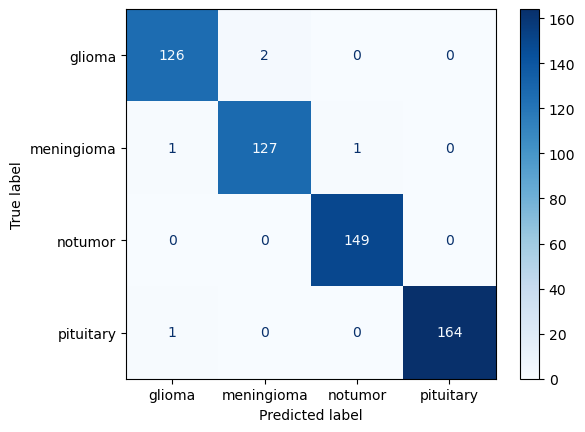

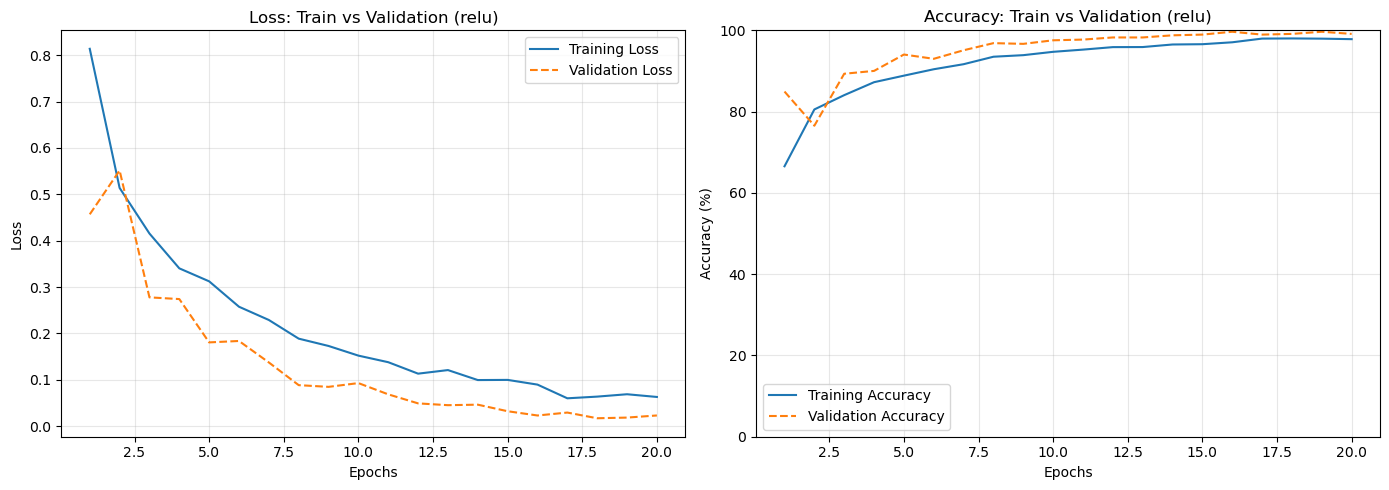

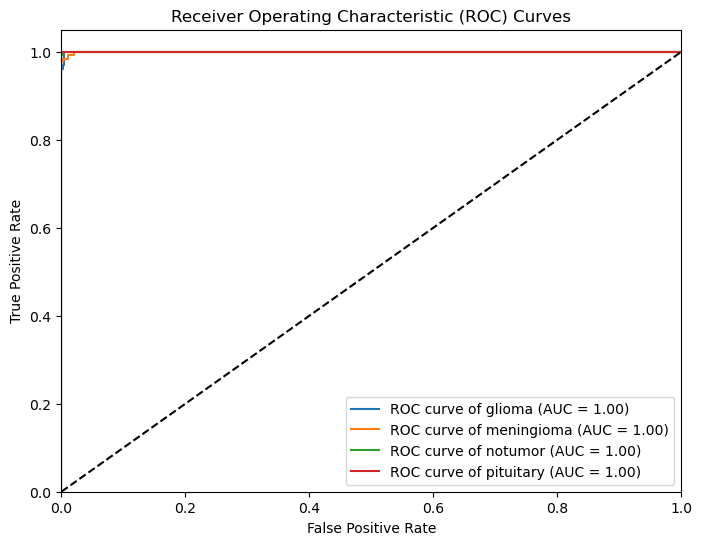

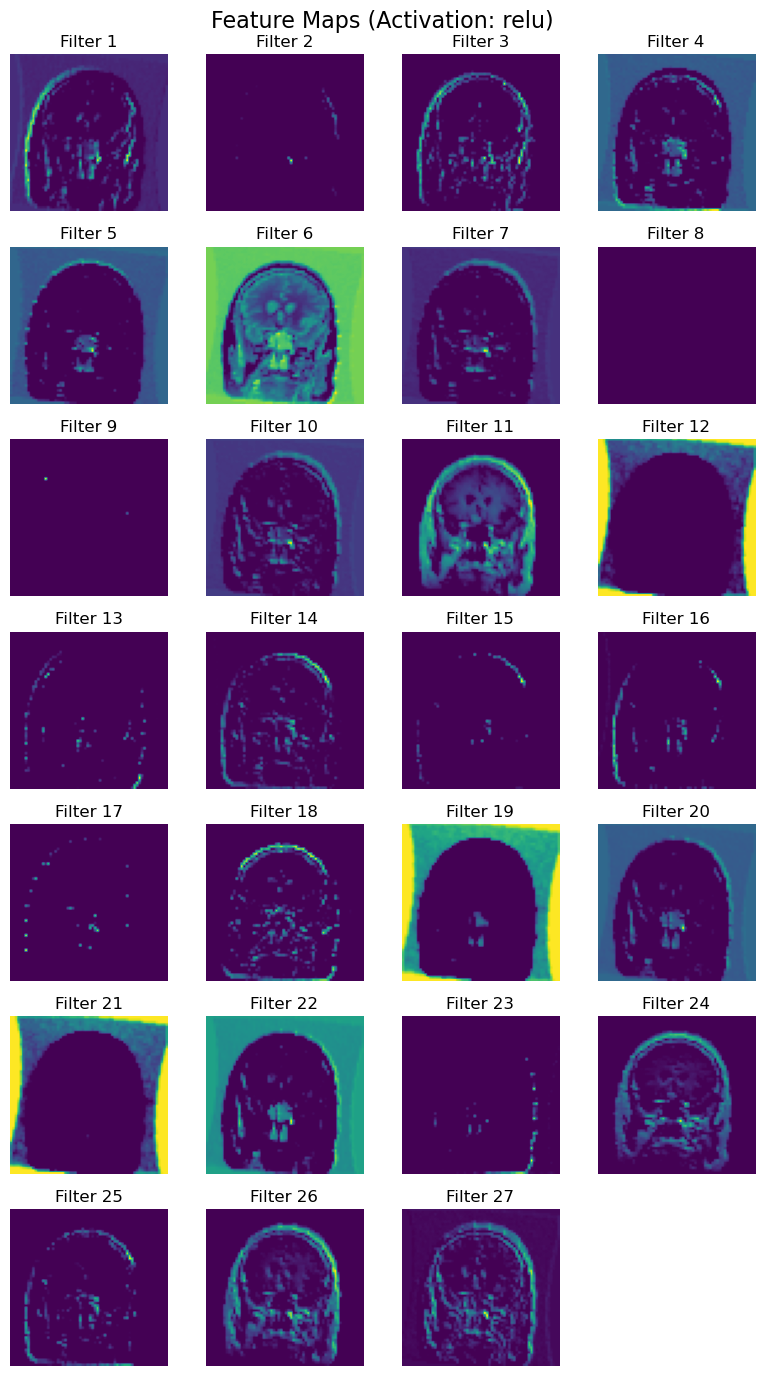

Classification Report: 
 {'glioma': {'precision': 0.984375, 'recall': 0.984375, 'f1-score': 0.984375, 'support': 128}, 'meningioma': {'precision': 0.9844961240310077, 'recall': 0.9844961240310077, 'f1-score': 0.9844961240310077, 'support': 129}, 'notumor': {'precision': 0.9933333333333333, 'recall': 1.0, 'f1-score': 0.9966555183946488, 'support': 149}, 'pituitary': {'precision': 1.0, 'recall': 0.9939393939393939, 'f1-score': 0.9969604863221885, 'support': 165}, 'accuracy': 0.9912434325744308, 'macro avg': {'precision': 0.9905511143410852, 'recall': 0.9907026294926005, 'f1-score': 0.9906217821869612, 'support': 571}, 'weighted avg': {'precision': 0.9912551079976649, 'recall': 0.9912434325744308, 'f1-score': 0.9912436996216529, 'support': 571}}
Test Accuracy: 0.8551

Training with activation: tanh
  Epoch    |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc   
----------------------------------------------------------------------
    1      |    0.7949    |    67.72   % |    0.564

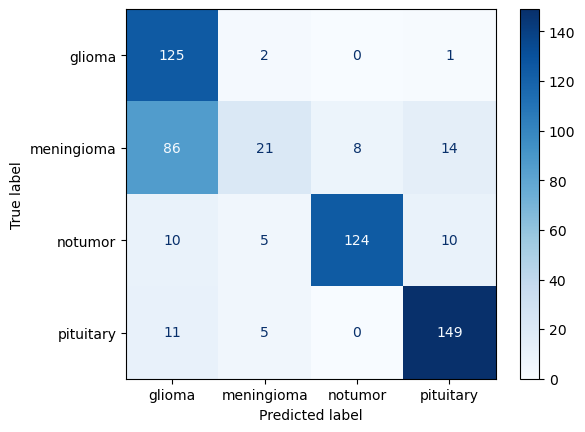

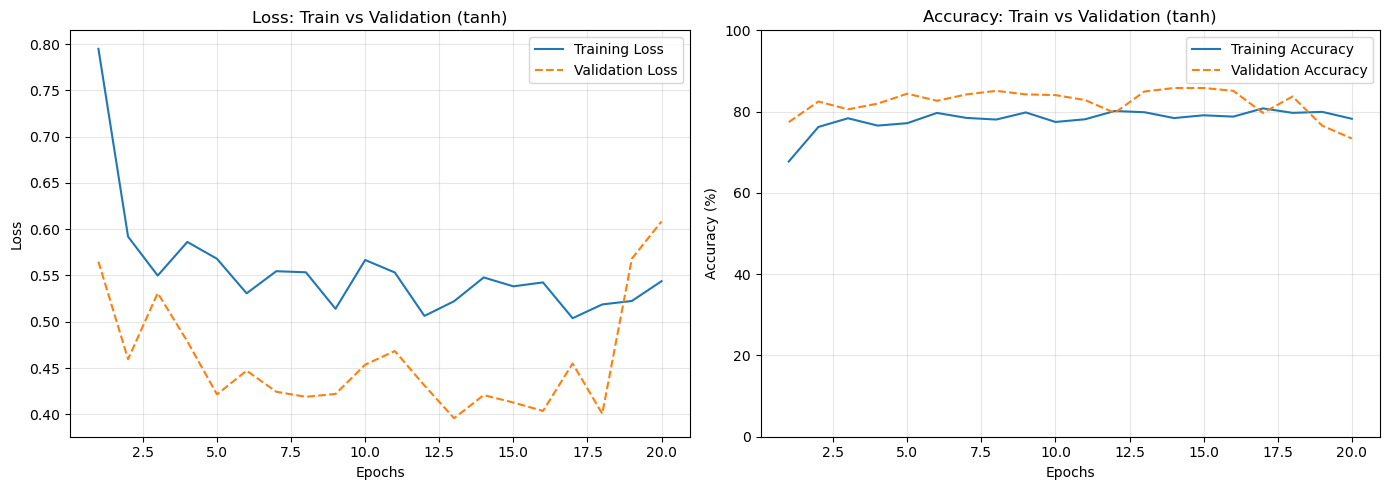

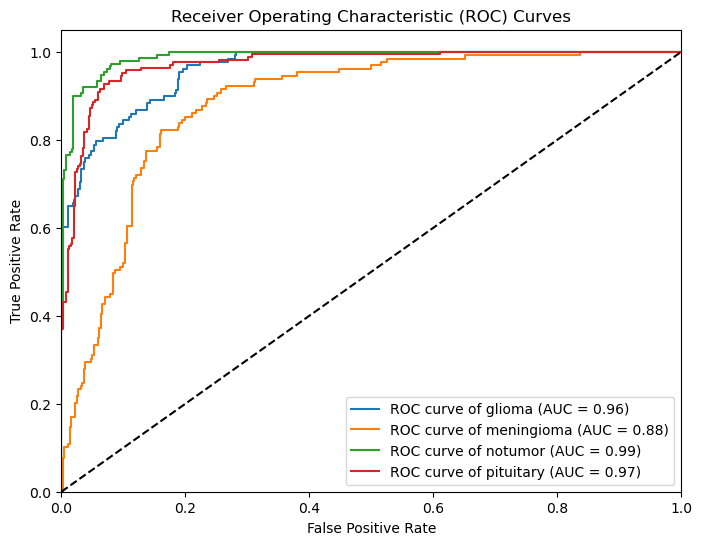

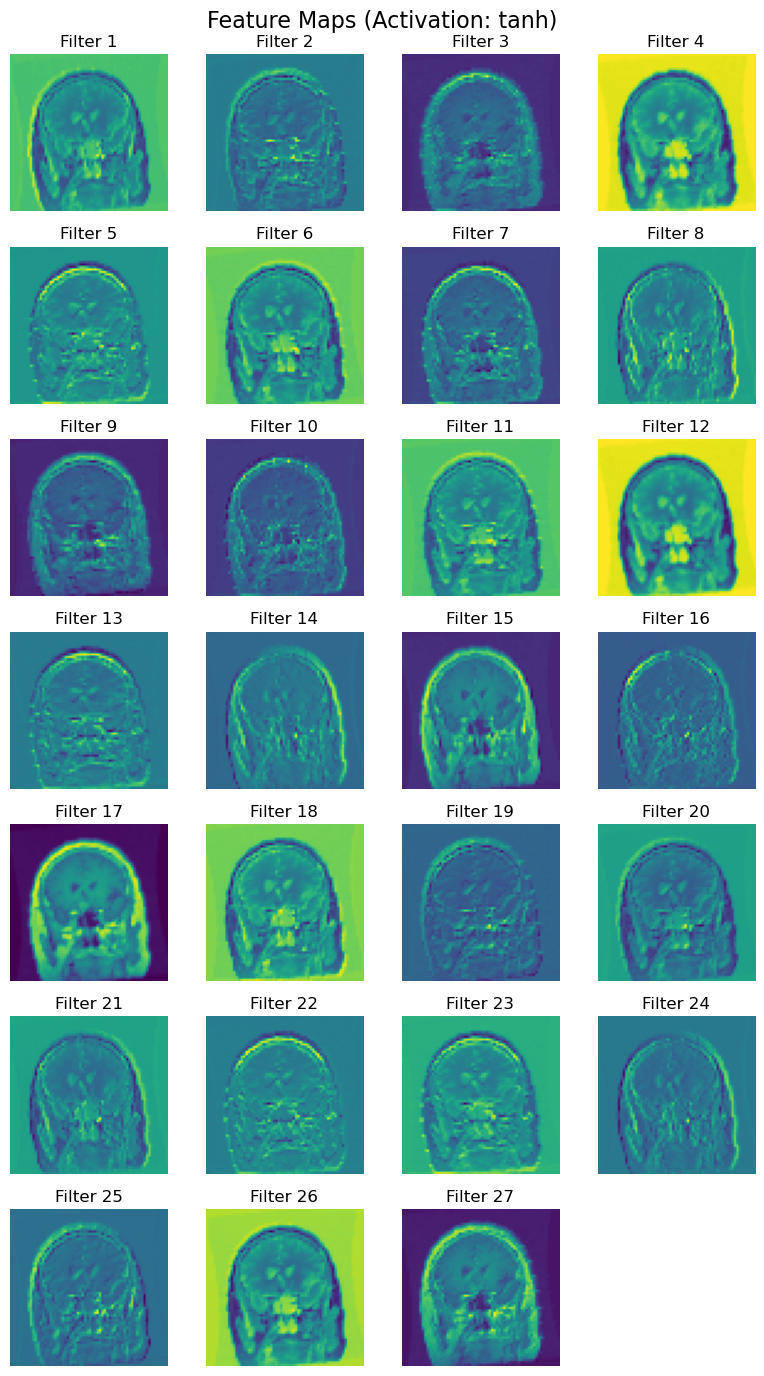

Classification Report: 
 {'glioma': {'precision': 0.5387931034482759, 'recall': 0.9765625, 'f1-score': 0.6944444444444445, 'support': 128}, 'meningioma': {'precision': 0.6363636363636364, 'recall': 0.16279069767441862, 'f1-score': 0.2592592592592593, 'support': 129}, 'notumor': {'precision': 0.9393939393939394, 'recall': 0.8322147651006712, 'f1-score': 0.8825622775800712, 'support': 149}, 'pituitary': {'precision': 0.8563218390804598, 'recall': 0.9030303030303031, 'f1-score': 0.8790560471976401, 'support': 165}, 'accuracy': 0.7338003502626971, 'macro avg': {'precision': 0.7427181295715779, 'recall': 0.7186495664513481, 'f1-score': 0.6788305071203538, 'support': 571}, 'weighted avg': {'precision': 0.7571264916817185, 'recall': 0.7338003502626971, 'f1-score': 0.6985628029428625, 'support': 571}}
Test Accuracy: 0.8551

Training with activation: sigmoid
  Epoch    |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc   
-------------------------------------------------------------------

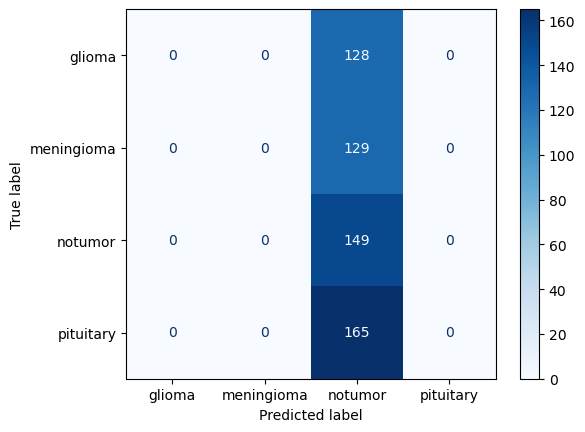

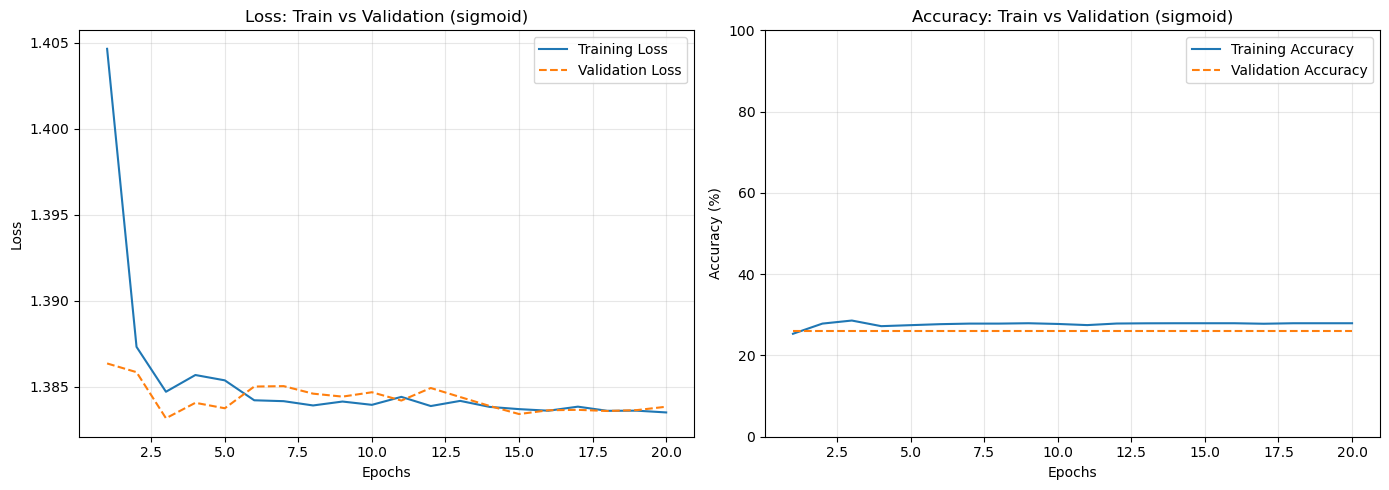

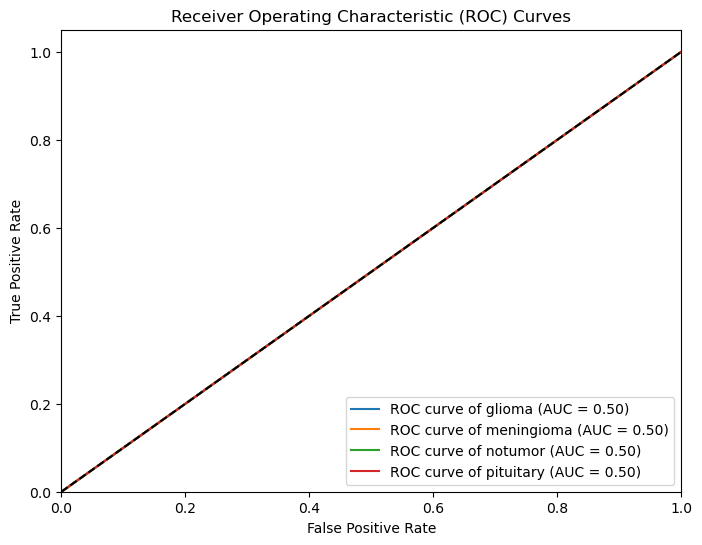

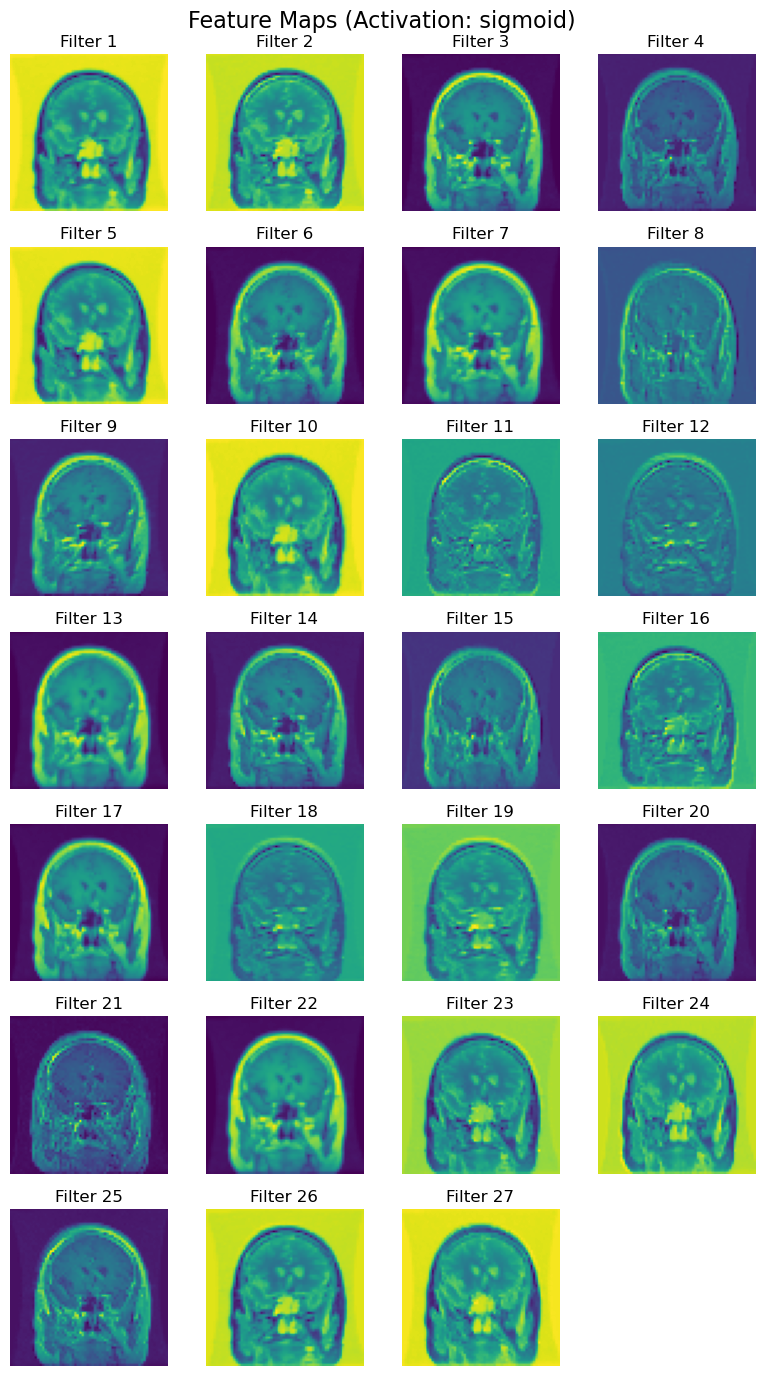

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
 {'glioma': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 128}, 'meningioma': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 129}, 'notumor': {'precision': 0.2609457092819615, 'recall': 1.0, 'f1-score': 0.41388888888888886, 'support': 149}, 'pituitary': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 165}, 'accuracy': 0.2609457092819615, 'macro avg': {'precision': 0.06523642732049037, 'recall': 0.25, 'f1-score': 0.10347222222222222, 'support': 571}, 'weighted avg': {'precision': 0.06809266319266595, 'recall': 0.2609457092819615, 'f1-score': 0.10800252967503404, 'support': 571}}
Test Accuracy: 0.8551

Training with activation: leaky_relu
  Epoch    |  Train Loss  |  Train Acc   |   Val Loss   |   Val Acc   
----------------------------------------------------------------------
    1      |    0.7697    |    69.52   % |    0.6304    |    74.78   %
    2      |    0.4930    |    81.07   % |    0.3678    |    86.51   %
  

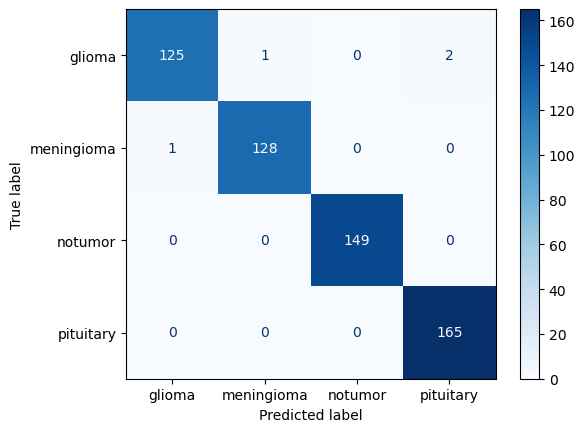

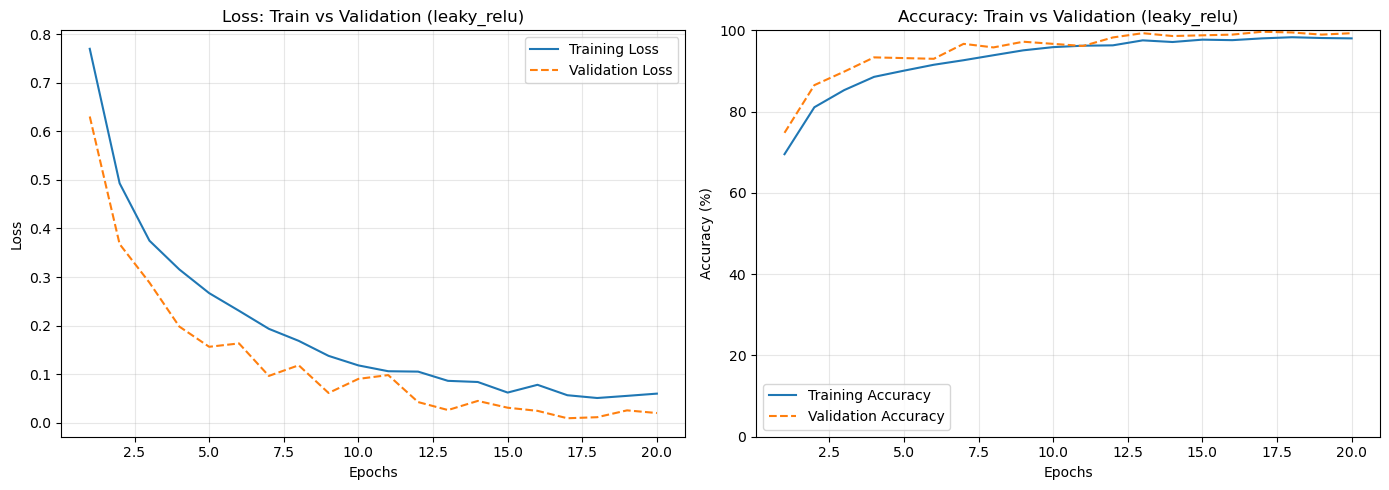

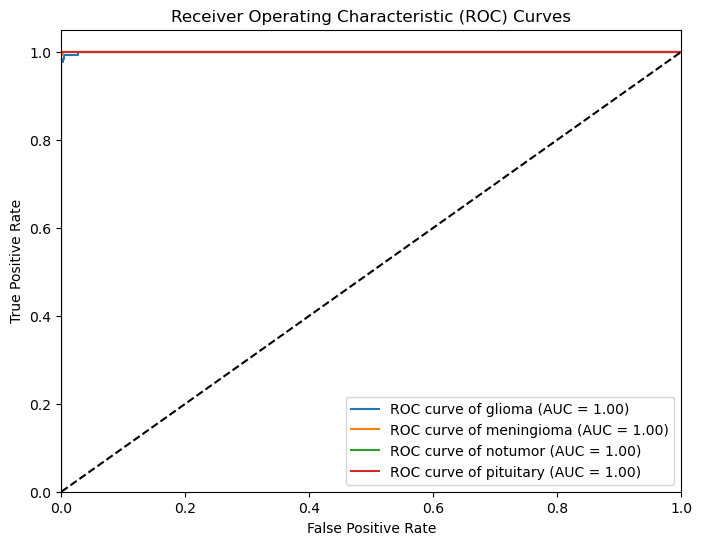

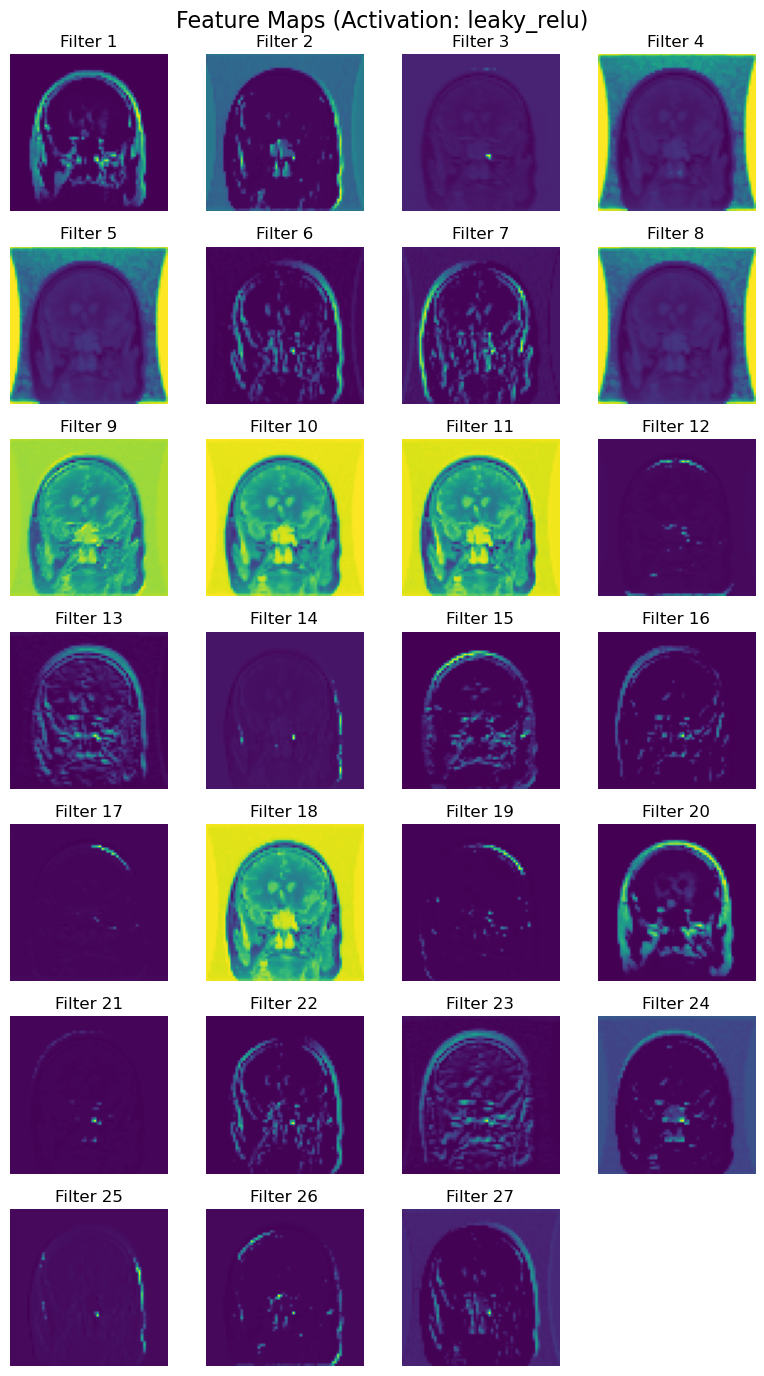

Classification Report: 
 {'glioma': {'precision': 0.9920634920634921, 'recall': 0.9765625, 'f1-score': 0.9842519685039369, 'support': 128}, 'meningioma': {'precision': 0.9922480620155039, 'recall': 0.9922480620155039, 'f1-score': 0.9922480620155039, 'support': 129}, 'notumor': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 149}, 'pituitary': {'precision': 0.9880239520958084, 'recall': 1.0, 'f1-score': 0.9939759036144578, 'support': 165}, 'accuracy': 0.9929947460595446, 'macro avg': {'precision': 0.9930838765437011, 'recall': 0.992202640503876, 'f1-score': 0.9926189835334747, 'support': 571}, 'weighted avg': {'precision': 0.993008895061183, 'recall': 0.9929947460595446, 'f1-score': 0.9929777164008572, 'support': 571}}
Test Accuracy: 0.8551


In [41]:
compare_results = compare_activations(["relu", "tanh", "sigmoid", "leaky_relu"], trainloader, valloader, testloader, device, epochs=20)

In [42]:
compare_results

{'relu': {'train_info': {'history': {'train_loss': [0.8138160503545061,
     0.5138406052308924,
     0.4155123472547665,
     0.3404321747751129,
     0.3124306394355972,
     0.2576530041480933,
     0.22908033841714806,
     0.1888517053479574,
     0.17307992877454317,
     0.15225012615030886,
     0.13806298092341557,
     0.11337333781180345,
     0.1210861008024725,
     0.09956602788209415,
     0.09991030236940925,
     0.08975549374579214,
     0.06023268650627645,
     0.06387326490598358,
     0.06897898066589343,
     0.06311627641061474],
    'train_acc': [0.6654411764705882,
     0.8053221288515406,
     0.8405112044817927,
     0.8723739495798319,
     0.8884803921568627,
     0.9042366946778712,
     0.9166666666666666,
     0.9350490196078431,
     0.9389005602240896,
     0.9471288515406162,
     0.9525560224089635,
     0.9586834733893558,
     0.958858543417367,
     0.9651610644257703,
     0.9658613445378151,
     0.9705882352941176,
     0.9796918767507002,
   

In [56]:
for info in compare_results:
    print("-"*50)
    print(info)
    info = compare_results[info]
    train = info['train_info']
    report = classification_report(train['labels'], train['preds'], target_names=dataset.classes)
    print("-"*50)
    print("Classification Report: \n",report)

--------------------------------------------------
relu
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       128
  meningioma       0.98      0.98      0.98       129
     notumor       0.99      1.00      1.00       149
   pituitary       1.00      0.99      1.00       165

    accuracy                           0.99       571
   macro avg       0.99      0.99      0.99       571
weighted avg       0.99      0.99      0.99       571

--------------------------------------------------
tanh
--------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

      glioma       0.54      0.98      0.69       128
  meningioma       0.64      0.16      0.26       129
     notumor       0.94      0.83      0.88       149
   pituitary       0.86      0.90      0.88       165

    accuracy                 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for info in compare_results:
    print(info)

relu
tanh
sigmoid
leaky_relu


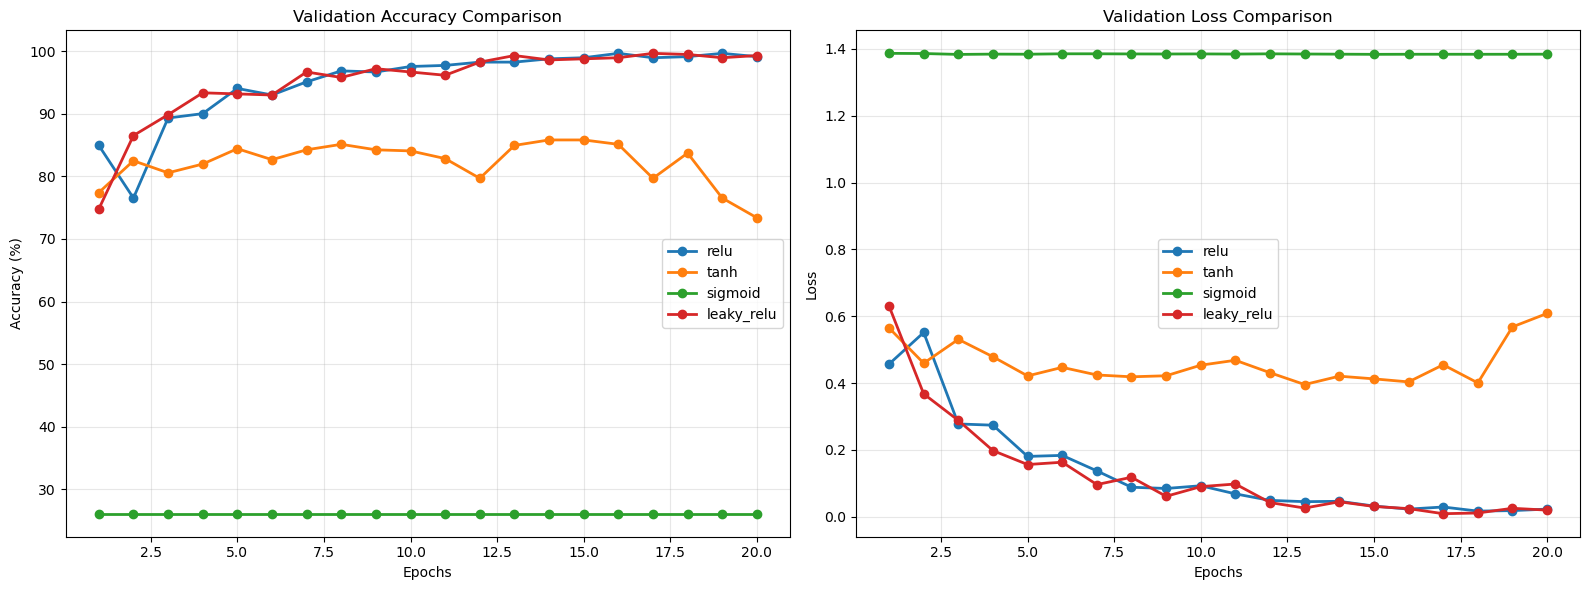

In [58]:
import matplotlib.pyplot as plt

def plot_model_comparison(compare_results):
    """
    Plots a comparison of Validation Accuracy and Validation Loss 
    for all models in compare_results.
    """
    plt.figure(figsize=(16, 6))
    
    # ---------------------------------------------------
    # Plot 1: Validation Accuracy Comparison (Higher is better)
    # ---------------------------------------------------
    plt.subplot(1, 2, 1)
    
    for activation_name in compare_results:
        # Extract history
        model_data = compare_results[activation_name]
        history = model_data['train_info']['history']
        
        # Convert to percentage
        val_acc_pct = [acc * 100 for acc in history['val_acc']]
        epochs = range(1, len(val_acc_pct) + 1)
        
        # Plot
        plt.plot(epochs, val_acc_pct, marker='o', linewidth=2, label=activation_name)

    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ---------------------------------------------------
    # Plot 2: Validation Loss Comparison (Lower is better)
    # ---------------------------------------------------
    plt.subplot(1, 2, 2)
    
    for activation_name in compare_results:
        # Extract history
        model_data = compare_results[activation_name]
        history = model_data['train_info']['history']
        
        # Get loss
        val_loss = history['val_loss']
        epochs = range(1, len(val_loss) + 1)
        
        # Plot
        plt.plot(epochs, val_loss, marker='o', linewidth=2, label=activation_name)

    plt.title("Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Run the function ---
plot_model_comparison(compare_results)

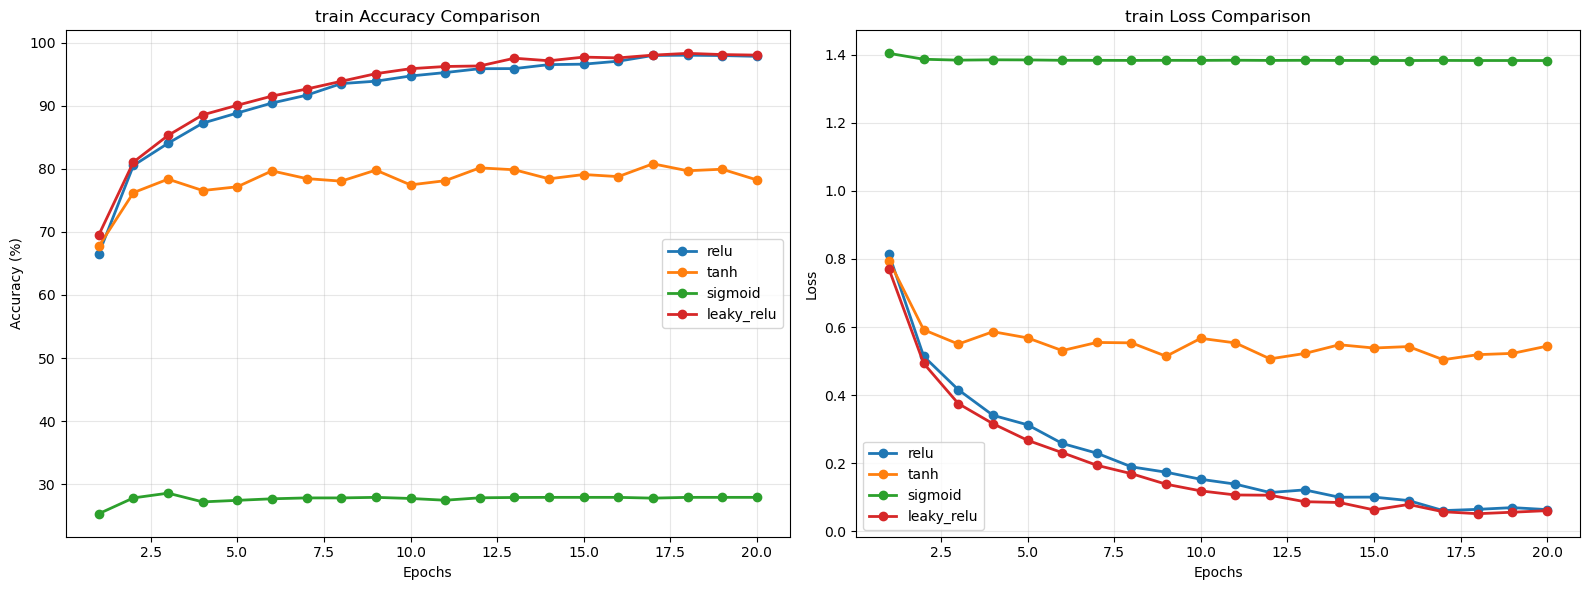

In [60]:
import matplotlib.pyplot as plt

def plot_model_comparison(compare_results):
    """
    Plots a comparison of Validation Accuracy and Validation Loss 
    for all models in compare_results.
    """
    plt.figure(figsize=(16, 6))
    
    # ---------------------------------------------------
    # Plot 1: Validation Accuracy Comparison (Higher is better)
    # ---------------------------------------------------
    plt.subplot(1, 2, 1)
    
    for activation_name in compare_results:
        # Extract history
        model_data = compare_results[activation_name]
        history = model_data['train_info']['history']
        
        # Convert to percentage
        val_acc_pct = [acc * 100 for acc in history['train_acc']]
        epochs = range(1, len(val_acc_pct) + 1)
        
        # Plot
        plt.plot(epochs, val_acc_pct, marker='o', linewidth=2, label=activation_name)

    plt.title("train Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ---------------------------------------------------
    # Plot 2: Validation Loss Comparison (Lower is better)
    # ---------------------------------------------------
    plt.subplot(1, 2, 2)
    
    for activation_name in compare_results:
        # Extract history
        model_data = compare_results[activation_name]
        history = model_data['train_info']['history']
        
        # Get loss
        val_loss = history['train_loss']
        epochs = range(1, len(val_loss) + 1)
        
        # Plot
        plt.plot(epochs, val_loss, marker='o', linewidth=2, label=activation_name)

    plt.title("train Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Run the function ---
plot_model_comparison(compare_results)